<a href="https://colab.research.google.com/github/zia207/Deep-Neural-Network-Satellite-Image-Classification-in-Google-Colaboratory-iPython-Note-Book-/blob/master/NoteBook/Machine_Learning/Tree_based/03-01-02-03-tree-based-models-bagging-cforest-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.3 Conditional Random Forest (cforest)

Conditional Random Forest (cforest) builds on ensemble learning method that constructs multiple decision trees but uses **conditional inference trees** (implemented via the `ctree` algorithm) instead of standard CART (Classification and Regression Trees). These trees are based on a statistical framework that tests the independence between predictors and the response variable to guide splitting decisions. This notebook will cover the theoretical background, implementation details, and practical applications of cforest in R.

## Overview

A **Conditional Random Forest (cforest)** is an extension of the Random Forest algorithm that uses **conditional inference trees** as its base learners instead of standard decision trees. It was introduced to address some limitations of traditional Random Forests, particularly in handling variable selection bias and providing more robust statistical inference. The `cforest` algorithm is implemented in the R package `party` and is designed to work within a conditional inference framework, which ensures unbiased variable selection and better handling of complex data structures.

Key Features of cforest:

-   `Unbiased Variable Selection`: Unlike traditional Random Forests, which may favor variables with more categories or continuous variables, cforest uses conditional inference to select variables without bias.

-   `Statistical Rigor`: It incorporates permutation-based significance tests to decide splits, making it more robust for datasets with complex relationships or correlated predictors. -`Flexibility`: cforest can handle various types of response variables (e.g., continuous, categorical, survival data) and is less sensitive to overfitting in certain scenarios.


### How Does Conditional Random Forest (cforest) Work?

The **Conditional Random Forest (cforest)** algorithm combines the ensemble approach of Random Forests with the **conditional inference framework** to reduce bias in variable selection and handle mixed data types effectively. Below is a detailed explanation, incorporating mathematical formulations where relevant:

1. Input Data

-   `Dataset`: Let $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$ be the dataset, where:

  -   $\mathbf{x}_i = (x_{i1}, x_{i2}, \dots, x_{ip})$ is a vector of $p$ predictor variables (numeric or categorical).

  -   $y_i$ is the response variable (continuous for regression, categorical for classification).

-   The goal is to predict $y$ given $\mathbf{x}$ using an ensemble of conditional inference trees.

2. Bootstrapping or Subsampling

-   `Bagging`: For each tree $t = 1, 2, \dots, T$, a bootstrap sample $D_t$ is drawn from $D$ with replacement, typically of size $n$. The probability that a specific observation $(\mathbf{x}_i, y_i)$ is included in $D_t$ is approximately $1 - (1 - 1/n)^n \approx 1 - e^{-1} \approx 0.632$.

-   `Subsampling`: Alternatively, a random subset of size $m< n$ is drawn without replacement. This reduces correlation between trees compared to bagging.

-   `Out-of-Bag (OOB) Sample`: Observations not included in $D_t$ form the OOB sample, used for estimating generalization error.

3.  Building Conditional Inference Trees

Each tree in cforest is a **conditional inference tree** (`ctree`), constructed using a statistical framework to ensure unbiased variable selection. The process involves:

3.1  `Variable Selection via Conditional Inference`:

  -   At each node, cforest tests the null hypothesis $H_0: Y \perp X_j \mid \mathbf{X}_{-j}$ for each predictor $X_j$, where $\mathbf{X}_{-j}$ denotes all other predictors.

    -   The test is based on a `permutation test`:

        -   Compute a test statistic (e.g., for regression, a correlation-based statistic; for classification, a chi-squared or Gini-based statistic).

        -   Permute the values of $X_j$ while keeping $Y$ and $\mathbf{X}_{-j}$ fixed to generate a null distribution.

        -   Calculate the p-value as the proportion of permuted test statistics exceeding the observed statistic:

$$  p_j = P(T(\mathbf{X}_j^{\text{perm}}, Y) \geq T(\mathbf{X}_j, Y) \mid \mathbf{X}_{-j}) $$

        
 - Select the predictor $X_j$ with the smallest p-value, provided $p_j < \alpha$ (e.g., $\alpha = 0.05$).

  - This ensures unbiased variable selection, unlike standard Random Forest, which may favor variables with more split points (e.g., continuous variables).


3.2 `Split Point Selection`:

  -   For the selected predictor $X_j$:

        -   If $X_j$ is continuous, evaluate split points $\in {x_{ij} \mid i \in \text{node}}$.

        -   If $X_j$ is categorical with levels ${c_1, c_2, \dots, c_k}$, consider all possible binary splits (e.g., ${c_1, c_2}$ vs. ${c_3, \dots, c_k}$).

    -   Choose the split that maximizes a test statistic, such as the standardized linear statistic:

$$  T_j(s) = \sum_{i \in \text{node}} w_i (y_i - \bar{y}) (x_{ij} - \bar{x}_j) \cdot I(x_{ij} \leq s) $$

        
 where $w_i $ are weights (typically 1), and $I$ is the indicator function.


-   The split maximizes the separation of $Y$ values in the child nodes.

3.3  `Recursive Partitioning*`

   -   Split the node into two child nodes based on the selected variable and split point.

   -   Recursively apply the above steps to each child node until a stopping criterion is met.

3.4  `topping Criteria`:

  -   Stop splitting if:

       -   No predictor has a p-value $< \alpha$ (no significant association).

        -   The node size is below a threshold (e.g., $n_{\text{min}} = 10$).

        -   A maximum tree depth is reached.

    -   The terminal node assigns a prediction (e.g., mean $y$ for regression, majority class for classification).

4. Ensemble Prediction

-   `Regression`:

   -   For a new observation $\mathbf{x}$, each tree \$t \$ predicts $\hat{y}_t(\mathbf{x})$.

   -   The final prediction is the average across all trees:

$$ \hat{y}(\mathbf{x}) = \frac{1}{T} \sum_{t=1}^T \hat{y}_t(\mathbf{x}) $$

-   `Classification`:

  -   Each tree votes for a class $\hat{y}_t(\mathbf{x})$.
  -   The final prediction is the majority class or averaged class probabilities:

$$  \hat{y}(\mathbf{x}) = \arg\max_c \left( \frac{1}{T} \sum_{t=1}^T I(\hat{y}_t(\mathbf{x}) = c) \right) $$

-   `OOB Error`:

   -   For each observation $(\mathbf{x}_i, y_i)$, use only trees where $(\mathbf{x}_i, y_i) \notin D_t$.

  -   Compute OOB predictions and estimate error (e.g., RMSE for regression, misclassification rate for classification).

5. Variable Importance

-   `Permutation Importance`:

  -   For predictor $X_j$, permute its values in the OOB sample for tree $t$.
  
  -   Compute the increase in OOB error (e.g., MSE for regression):

$$  \text{Importance}(X_j) = \frac{1}{T} \sum_{t=1}^T \left( \text{MSE}_{\text{perm},t} - \text{MSE}_{\text{orig},t} \right) $$

-   Higher values indicate greater importance.


Below is a flowchart illustrating the process of building a Conditional Random Forest (cforest):

![alt text](http://drive.google.com/uc?export=view&id=1nRfrCMuys21NkrUx43xOsJ_mkTSQDNyr)


### Comparison with Standard Random Forest

| **Aspect** | **Random Forest (CART)** | **Conditional Random Forest (cforest)** |
|------------------|---------------------------|---------------------------|
| **Base Learner** | CART (decision trees) | Conditional inference trees (`ctree`) |
| **Variable Selection** | Based on impurity (Gini, MSE) | Based on conditional inference (p-values) |
| **Bias in Splitting** | Biased toward variables with more categories | Unbiased, uses permutation tests |
| **Computational Speed** | Faster | Slower due to statistical tests |
| **Implementation** | Widely available (e.g., scikit-learn, R) | Primarily in R’s `party` package |
| **Interpretability** | Less statistically rigorous | More rigorous (p-value-based splits) |

## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314972 sha256=2e662a66fca6c78b3c704a7b1075da37f69d1164b49cb9900148dbbba5b90640
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Conditional Random Forest (cforest) from scratch

I'll implement conditional Random Forest models for both classification (using iris dataset) and regression (using Boston Housing dataset) in R from scratch. Since you specified not to use any R packages for the Random Forest implementation, The implementation will include tree building, bootstrapping, and prediction logic without relying on external libraries.


### Decision tree node structure

The `create_node` function creates a decision tree node as a list with `feature`, `threshold`, `left`, `right`, `value` (all NULL), and `is_leaf` (FALSE), used for building Random Forest trees.

In [4]:
%%R
# Node structure for decision tree
create_node <- function() {
  list(
    feature = NULL,
    threshold = NULL,
    left = NULL,
    right = NULL,
    value = NULL,
    is_leaf = FALSE
  )
}

### Splitting criteria (Gini for classification, variance reduction for regression)

The following functions calculate splitting criteria for classification and regression tasks:

- `gini_impurity`: Calculates Gini impurity for classification. Returns 0 if no labels; otherwise, computes 1 minus the sum of squared probabilities of each class.
- `variance`: Calculates variance for regression. Returns 0 if one or no values; otherwise, computes average squared deviation from the mean.

In [6]:
%%R
# Gini impurity for classification
gini_impurity <- function(labels) {
  if (length(labels) == 0) return(0)
  probs <- table(labels) / length(labels)
  1 - sum(probs^2)
}

# Variance for regression
variance <- function(values) {
  if (length(values) <= 1) return(0)
  mean_val <- mean(values)
  sum((values - mean_val)^2) / length(values)
}


### Finding the best split for classification and regression

The following functions find the best split for classification and regression tasks:

- `find_best_split_classification`: Finds the best split for classification by testing each feature and threshold (midpoints of sorted values). It selects the split with the lowest weighted Gini impurity, returning the feature, threshold, and Gini value.

- `find_best_split_regression`: Finds the best split for regression by testing each feature and threshold. It selects the split with the lowest weighted variance, returning the feature, threshold, and variance.

In [7]:
%%R
# Find best split for classification
find_best_split_classification <- function(data, labels, features) {
  best_gini <- Inf
  best_feature <- NULL
  best_threshold <- NULL

  for (feature in features) {
    values <- data[, feature]
    unique_vals <- sort(unique(values))
    thresholds <- (unique_vals[-length(unique_vals)] + unique_vals[-1]) / 2

    for (threshold in thresholds) {
      left_idx <- values <= threshold
      right_idx <- !left_idx

      if (sum(left_idx) == 0 || sum(right_idx) == 0) next

      left_labels <- labels[left_idx]
      right_labels <- labels[right_idx]

      gini_left <- gini_impurity(left_labels)
      gini_right <- gini_impurity(right_labels)
      weight_left <- sum(left_idx) / length(labels)
      weight_right <- sum(right_idx) / length(labels)
      gini_total <- weight_left * gini_left + weight_right * gini_right

      if (gini_total < best_gini) {
        best_gini <- gini_total
        best_feature <- feature
        best_threshold <- threshold
      }
    }
  }

  list(feature = best_feature, threshold = best_threshold, gini = best_gini)
}

# Find best split for regression
find_best_split_regression <- function(data, values, features) {
  best_var <- Inf
  best_feature <- NULL
  best_threshold <- NULL

  for (feature in features) {
    vals <- data[, feature]
    unique_vals <- sort(unique(vals))
    thresholds <- (unique_vals[-length(unique_vals)] + unique_vals[-1]) / 2

    for (threshold in thresholds) {
      left_idx <- vals <= threshold
      right_idx <- !left_idx

      if (sum(left_idx) == 0 || sum(right_idx) == 0) next

      left_vals <- values[left_idx]
      right_vals <- values[right_idx]

      var_left <- variance(left_vals)
      var_right <- variance(right_vals)
      weight_left <- sum(left_idx) / length(values)
      weight_right <- sum(right_idx) / length(values)
      var_total <- weight_left * var_left + weight_right * var_right

      if (var_total < best_var) {
        best_var <- var_total
        best_feature <- feature
        best_threshold <- threshold
      }
    }
  }

  list(feature = best_feature, threshold = best_threshold, variance = best_var)
}

### Random Forest ensemble creation

The `build_tree` function recursively builds a decision tree:
- Creates a node.
- Stops if max depth reached or data size ≤ min_size, setting node as leaf with majority class (classification) or mean value (regression).
- Randomly selects sqrt(features) for splitting.
- Finds best split using Gini (classification) or variance (regression).
- If no valid split, sets node as leaf.
- Splits data into left/right based on feature/threshold, recursively builds child nodes.
- Returns the node.

In [8]:
%%R
# Build a single decision tree
build_tree <- function(data, target, type = "classification", max_depth = 10, min_size = 5, depth = 0) {
  node <- create_node()

  # Stopping criteria
  if (depth >= max_depth || nrow(data) <= min_size) {
    node$is_leaf <- TRUE
    if (type == "classification") {
      node$value <- names(which.max(table(target)))
    } else {
      node$value <- mean(target)
    }
    return(node)
  }

  # Randomly select features (sqrt of total features)
  n_features <- ncol(data)
  mtry <- floor(sqrt(n_features))
  features <- sample(1:n_features, mtry)

  # Find best split
  if (type == "classification") {
    split <- find_best_split_classification(data, target, features)
  } else {
    split <- find_best_split_regression(data, target, features)
  }

  if (is.null(split$feature)) {
    node$is_leaf <- TRUE
    if (type == "classification") {
      node$value <- names(which.max(table(target)))
    } else {
      node$value <- mean(target)
    }
    return(node)
  }

  # Split data
  left_idx <- data[, split$feature] <= split$threshold
  right_idx <- !left_idx

  if (sum(left_idx) == 0 || sum(right_idx) == 0) {
    node$is_leaf <- TRUE
    if (type == "classification") {
      node$value <- names(which.max(table(target)))
    } else {
      node$value <- mean(target)
    }
    return(node)
  }

  # Create child nodes
  node$feature <- split$feature
  node$threshold <- split$threshold
  node$left <- build_tree(data[left_idx, ], target[left_idx], type, max_depth, min_size, depth + 1)
  node$right <- build_tree(data[right_idx, ], target[right_idx], type, max_depth, min_size, depth + 1)

  node
}

The `bootstrap_sample` function:

- Randomly samples `n` rows (with replacement) from data and target.
- Returns list of sampled data and target.

In [9]:
%%R
# Bootstrap sampling
bootstrap_sample <- function(data, target) {
  n <- nrow(data)
  idx <- sample(1:n, n, replace = TRUE)
  list(data = data[idx, ], target = target[idx])
}

The `random_forest` function:

- Creates a list of `n_trees` decision trees.
- For each tree, takes a bootstrap sample and builds a tree using `build_tree`.
- Returns a list with the trees and model type (classification or regression).

In [10]:
%%R
# Build Random Forest
random_forest <- function(data, target, type = "classification", n_trees = 100, max_depth = 10, min_size = 5) {
  trees <- list()
  for (i in 1:n_trees) {
    sample <- bootstrap_sample(data, target)
    tree <- build_tree(sample$data, sample$target, type, max_depth, min_size)
    trees[[i]] <- tree
  }
  list(trees = trees, type = type)
}


### Prediction functions for the Random Forest

- `predict_tree`: Predicts for one tree: returns leaf value if leaf node; else recursively follows left or right child based on feature/threshold comparison.

- `predict_rf`: Predicts for Random Forest: collects predictions from all trees for each row; returns majority class (classification) or mean value (regression).

In [11]:
%%R
# Predict for a single tree
predict_tree <- function(tree, row) {
  if (tree$is_leaf) return(tree$value)

  if (row[tree$feature] <= tree$threshold) {
    predict_tree(tree$left, row)
  } else {
    predict_tree(tree$right, row)
  }
}

# Predict for Random Forest
predict_rf <- function(forest, data) {
  predictions <- matrix(NA, nrow = nrow(data), ncol = length(forest$trees))

  for (i in 1:length(forest$trees)) {
    predictions[, i] <- apply(data, 1, function(row) predict_tree(forest$trees[[i]], row))
  }

  if (forest$type == "classification") {
    apply(predictions, 1, function(x) names(which.max(table(x))))
  } else {
    apply(predictions, 1, mean)
  }
}

### Example Usage: Classification

In [12]:
%%R
# Load datasets
data(iris)

# Classification: Iris dataset
set.seed(123)
train_idx <- sample(1:nrow(iris), 0.7 * nrow(iris))
train_iris <- iris[train_idx, ]
test_iris <- iris[-train_idx, ]

# Train and predict classification Random Forest
rf_class <- random_forest(train_iris[, 1:4], train_iris$Species, type = "classification", n_trees = 50)
pred_class <- predict_rf(rf_class, test_iris[, 1:4])

# Evaluate classification (accuracy)
accuracy <- mean(pred_class == test_iris$Species)
cat("Classification Accuracy (Iris):", accuracy, "\n")

Classification Accuracy (Iris): 0.9777778 


### Example Usage: Regression

In [13]:
%%R
data(Boston, package = "MASS")
# Regression: Boston Housing dataset
train_idx <- sample(1:nrow(Boston), 0.7 * nrow(Boston))
train_boston <- Boston[train_idx, ]
test_boston <- Boston[-train_idx, ]

# Train and predict regression Random Forest
rf_reg <- random_forest(train_boston[, -14], train_boston$medv, type = "regression", n_trees = 50)
pred_reg <- predict_rf(rf_reg, test_boston[, -14])

# Evaluate regression (RMSE)
rmse <- sqrt(mean((pred_reg - test_boston$medv)^2))
cat("Regression RMSE (Boston):", rmse, "\n")

Regression RMSE (Boston): 2.836893 


## Conditional Random Forest (cforest) in R

I'll guide you through performing Conditional Random Forest (cforest) classification and regression in R using the {partykit} package. I'll include steps for building, pruning, summarizing, plotting, predicting, and assessing variable importance, then compare CIT with CART (using the {rpart} package).

### Check amd Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:

In [14]:
%%R
packages <- c('tidyverse',
              'plyr',
              'partykit',
              'mlbench',
              'ggparty'
         )

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [15]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
tidyverse      plyr  partykit   mlbench   ggparty 
     TRUE      TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [16]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

### Check Loaded Packages

In [18]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:ggparty"   "package:mlbench"   "package:partykit" 
 [4] "package:mvtnorm"   "package:libcoin"   "package:grid"     
 [7] "package:plyr"      "package:lubridate" "package:forcats"  
[10] "package:stringr"   "package:dplyr"     "package:purrr"    
[13] "package:readr"     "package:tidyr"     "package:tibble"   
[16] "package:ggplot2"   "package:tidyverse" "package:tools"    
[19] "package:stats"     "package:graphics"  "package:grDevices"
[22] "package:utils"     "package:datasets"  "package:methods"  
[25] "package:base"     


### Classification Problem

This section demonstrates how to use Conditional Random Forest (cforest) for classification tasks in R, specifically using the `{party}` package. We will build a cforest model on the Health Insurance dataset, which contains information about individuals' choices of insurance products based on various features.

#### Data

For classification, we will use the {party} packages to build a cforest model on [Health Iinsurance](http://peopleanalytics-regression-book.org/data/health_insurance.csv) data. The dataset contains information about individuals' choices of insurance products based on various features.

We will use `read_csv()` function of {readr} package to import data as a **tidy** data.


In [17]:
%%R
# Load data
mf<-readr::read_csv("https://github.com/zia207/r-colab/raw/main/Data/Machine_Learning/health_insurance.csv")
glimpse(mf)
# convert factor
mf$product <- as.factor(mf$product)
mf$gender <- as.factor(mf$gender)
# Split Data to Train and Test
seeds = 11076
tr_prop = 0.70
# training data (70% data)
train= ddply(mf,.(product, gender ),
                 function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test = ddply(mf, .(product , gender),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)

Rows: 1448 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): product, gender
dbl (4): age, household, position_level, absent

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1,448
Columns: 6
$ product        <chr> "C", "A", "C", "A", "A", "A", "A", "B", "C", "B", "B", …
$ age            <dbl> 57, 21, 66, 36, 23, 31, 37, 37, 55, 66, 58, 62, 31, 45,…
$ household      <dbl> 2, 7, 7, 4, 0, 5, 3, 0, 3, 2, 1, 2, 2, 5, 3, 5, 4, 7, 7…
$ position_level <dbl> 2, 2, 2, 2, 2, 1, 3, 3, 3, 4, 2, 2, 2, 2, 4, 4, 4, 4, 4…
$ gender         <chr> "Male", "Male", "Male", "Female", "Male", "Male", "Male…
$ absent         <dbl> 10, 7, 1, 6, 11, 14, 12, 25, 3, 18, 1, 25, 0, 10, 20, 2…


#### Fit the cforest Model

The `cforest()` function in the R `{party}` package builds a **conditional random forest** using **conditional inference trees** as base learners. It fits an ensemble of trees on bootstrap samples, with random feature selection at each split. Unlike `randomForest`, it uses unbiased splitting (avoiding bias toward variables with many categories) and aggregates predictions via observation weights. Key parameters include `ntree` (number of trees), `mtry` (number of features per split), and `mincriterion` (tree depth control). It supports classification, regression, censored responses, and multivariate outcomes, with out-of-bag (OOB) predictions via `predict(..., OOB = TRUE)`.

In [19]:
%%R
# Fit the cforest model
set.seed(seeds)
cforest_model <- cforest(product ~ age + household + position_level + absent + gender,
                         data = train,
                         control = ctree_control( mtry = floor(sqrt(5)),
                                                  teststat = "quad",
                                                  testtype = "Univariate",
                                                  mincriterion = 0.95))
summary(cforest_model)

         Length Class      Mode    
nodes    500    -none-     list    
data       6    data.frame list    
weights  500    -none-     list    
fitted     2    data.frame list    
terms      3    terms      call    
info       2    -none-     list    
trafo      1    -none-     function
predictf   2    terms      call    


#### Prediction and Evaluation

In [20]:
%%R
# Predict with holdout test data
cforest_predictions <- predict(cforest_model, newdata = test)

# SValidate model
cforest_accuracy <- mean(cforest_predictions == test$product)
cat("CIT Classification Accuracy:", cforest_accuracy, "\n")

CIT Classification Accuracy: 0.8287671 


#### Variable Importance

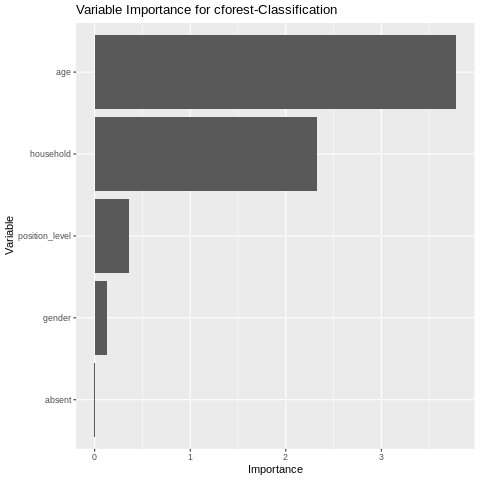

In [21]:
%%R
# Calculate variable importance
var_imp_cforest <- varimp(cforest_model)
var_imp_cforest <- sort(var_imp_cforest, decreasing = TRUE) # Sort by importance
var_imp_cforest <- data.frame(Variable = names(var_imp_cforest), Importance = var_imp_cforest)
# plot variable importance
ggplot(var_imp_cforest, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Variable Importance for cforest-Classification", x = "Variable", y = "Importance")

### Regression Example

For regression, we will use the `cforest()` function from the `{partykit}` package to build a Conditional Random Forest model on the Soil Organic Carbon (SOC) dataset. This dataset contains various soil properties and their relationship with SOC.


#### Data

In [22]:
%%R
# Read file from github
mf = readr::read_csv( "https://github.com//zia207/r-colab/raw/main/Data/Machine_Learning/gp_soil_data.csv")
# Create a data frame with selected variables
df <- mf %>% dplyr::select(SOC, DEM, Slope, Aspect, TPI, KFactor, SiltClay, MAT, MAP, NDVI, NLCD, FRG)

# Convert categorical variables to factors
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)

# Set seed for reproducibility
seeds <- 11076
tr_prop <- 0.70

# Split data into training and test sets, stratified by NLCD and FRG
set.seed(seeds)
train <- ddply(df, .(NLCD, FRG),
               function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test <- ddply(df, .(NLCD, FRG),
              function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)

# Scale numeric features (exclude SOC, NLCD, FRG)
train[-c(1, 11, 12)] <- scale(train[-c(1, 11, 12)])
test[-c(1, 11, 12)] <- scale(test[-c(1, 11, 12)])

Rows: 467 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD, FRG
dbl (15): ID, FIPS, STATE_ID, Longitude, Latitude, SOC, DEM, Aspect, Slope, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Fit the cforest Model

In [24]:
%%R
# Fit the cforest model with unbiased control settings
set.seed(seeds)
cforest_model <- cforest(SOC ~ DEM + Slope + Aspect + TPI + KFactor + SiltClay + MAT + MAP + NDVI + NLCD + FRG,
                         data = train,
                         control = ctree_control( mtry = floor(sqrt(11)),
                                                  teststat = "quad",
                                                  testtype = "Univariate",
                                                  mincriterion = 0.95))

#### Prediction and Evaluation

In [25]:
%%R
# Make predictions on the test set
test$SOC.pred.cforest = predict(cforest_model, newdata = test)

# Evaluate performance
RMSE<- Metrics::rmse(test$SOC, test$SOC.pred.cforest)
MAE<- Metrics::mae(test$SOC, test$SOC.pred.cforest)
RMSE
MAE

[1] 2.919315


#### 1:1 Plot for Predicted vs Observed values


  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2

Attaching package: ‘ggpp’



    annotate




`geom_smooth()` using formula = 'y ~ x'


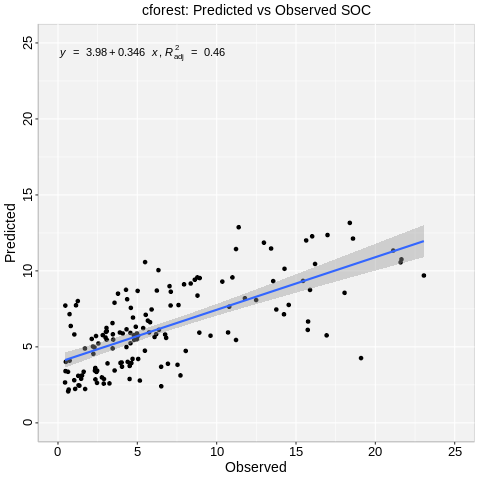

In [26]:
%%R
library(ggpmisc)
formula<-y~x

ggplot(test, aes(SOC,SOC.pred.cforest)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("cforest: Predicted vs Observed SOC") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

#### Variable Importance

In [ ]:
%%R
var_imp_cforest <- varimp(cforest_model)
var_imp_cforest <- sort(var_imp_cforest, decreasing = TRUE) # Sort by importance
var_imp_cforest <- data.frame(Variable = names(var_imp_cforest), Importance = var_imp_cforest)
# plot variable importance
ggplot(var_imp_cforest, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Variable Importance for cforest-Regression", x = "Variable", y = "Importance")


### Hyperparameter Tuning for cforest

To perform hyperparameter tuning for a `cforest` regression model using the provided code and the `{party}` package in R, you need to optimize key parameters such as `mtry` (number of features considered at each split), `ntree` (number of trees), and `mincriterion` (controls tree depth). Below is a concise guide to tune these parameters using a grid search with cross-validation, building on your code.

Steps for Hyperparameter Tuning:

1. **Define Parameter Grid**: Create a grid for `mtry`, `ntree`, and `mincriterion`.

   - `mtry`: Test values like `floor(sqrt(11))` (~3), 5, 7 (since you have 11 predictors).
   - `ntree`: Test 100, 500, 1000 (balance performance and computation).
   - `mincriterion`: Test 0.90, 0.95, 0.99 (controls tree pruning).


In [27]:
%%R
# Define parameter grid
param_grid <- expand.grid(
  mtry = c(3, 5, 7),
  ntree = 25,  # Reduced for speed; use c(100, 500, 1000) in production
  mincriterion = c(0.90, 0.95, 0.99)
)

2. **Cross-Validation Setup**: Use k-fold cross-validation (e.g., 5-fold) on the training data to evaluate each parameter combination.

In [28]:
%%R
# Function to calculate RMSE
rmse <- function(actual, predicted) sqrt(mean((actual - predicted)^2))
# 5-fold cross-validation
k <- 5
set.seed(seeds)
folds <- sample(rep(1:k, length.out = nrow(train)))
results <- data.frame()

for (i in 1:nrow(param_grid)) {
  mtry_val <- param_grid$mtry[i]
  ntree_val <- param_grid$ntree[i]
  mincriterion_val <- param_grid$mincriterion[i]

  cv_rmse <- numeric(k)
  for (j in 1:k) {
    # Split into training and validation folds
    train_cv <- train[folds != j, ]
    val_cv <- train[folds, ]

    # Train model
    model <- cforest(
      SOC ~ DEM + Slope + Aspect + TPI + KFactor + SiltClay + MAT + MAP + NDVI + NLCD + FRG,
      data = train_cv,
      ntree = ntree_val,
      control = ctree_control(
        mtry = mtry_val,
        teststat = "quad",
        testtype = "Univariate",
        mincriterion = mincriterion_val
      )
    )

    # Predict and calculate RMSE
    pred <- predict(model, newdata = val_cv)
    cv_rmse[j] <- rmse(val_cv$SOC, pred)
  }

  # Store mean RMSE
  results <- rbind(results, data.frame(
    mtry = mtry_val,
    ntree = ntree_val,
    mincriterion = mincriterion_val,
    mean_rmse = mean(cv_rmse)
  ))
}

3. **Select Best Parameters**: Choose the combination with the lowest average RMSE.

In [29]:
%%R
# Best parameters
best_params <- results[which.min(results$mean_rmse), ]
print("Best Parameters:")
print(best_params)

[1] "Best Parameters:"
  mtry ntree mincriterion mean_rmse
1    3    25          0.9  3.579862


4. **Train Final Model**: Fit the `cforest` model with the best parameters on the full training data and evaluate on the test set.

In [30]:
%%R
# Train final model with best parameters
set.seed(seeds)
final_model <- cforest(
  SOC ~ DEM + Slope + Aspect + TPI + KFactor + SiltClay + MAT + MAP + NDVI + NLCD + FRG,
  data = train,
  ntree = best_params$ntree,
  control = ctree_control(
    mtry = best_params$mtry,
    teststat = "quad",
    testtype = "Univariate",
    mincriterion = best_params$mincriterion
  )
)

5. Evaluate Final Model

Finally, evaluate the performance of the tuned model on the test set using RMSE.

In [31]:
%%R
# Evaluate on test set
test_pred <- predict(final_model, newdata = test)
test_rmse <- rmse(test$SOC, test_pred)
cat("Test RMSE:", test_rmse, "\n")

Test RMSE: 3.982229 


## Summary and Conclusion

Conditional Random Forest (cforest) is a powerful ensemble learning method that builds on the strengths of traditional Random Forests while addressing some of their limitations. By using conditional inference trees and permutation-based significance tests, cforest provides unbiased variable selection, robust statistical inference, and flexibility in handling various types of response variables. It is particularly useful in scenarios where variable importance and interpretability are crucial. This tutorial demonstrated how to implement cforest in R for both classification and regression tasks, showcasing its capabilities in real-world applications. By leveraging the strengths of cforest, data scientists and statisticians can build more reliable and interpretable models for complex datasets.

## References

1.  Hothorn, T., Hornik, K., & Zeileis, A. (2006). Unbiased Recursive Partitioning: A Conditional Inference Framework. *Journal of Computational and Graphical Statistics, 15*(3), 651–674.

2.  Strobl, C., Boulesteix, A.-L., Zeileis, A., & Hothorn, T. (2007). Bias in Random Forest Variable Importance Measures: Illustrations, Sources and a Solution. *BMC Bioinformatics, 8*(25).

3.  Hothorn, T., & Zeileis, A. (2015). partykit: A Modular Toolkit for Recursive Partytioning in R. *The Journal of Machine Learning Research, 16*(1), 3905–3909.

4.  Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning: Data Mining, Inference, and Prediction* (2nd ed.). Springer.

5.  [partykit R Package Documentation](https://cran.r-project.org/web/packages/partykit/partykit.pdf)
